# Predicting whether a binary will merge from initial conditions

The primary target of population synthesis is to understand the population of binaries that will result is a compact binary coalesence that is observable by gravitational-wave detectors.
However, this is a very rare outcome if initial conditions are chosen randomly.
Methods exist to optimize the choice of initial conditions to maximize the number of merging compact binaries.
In this task, you will develop another approach: training a classifier to predict if a set of initial conditions will result in a merger.

There are two reasons a binary won't result in a compact binary merger:
- a compact binary doesn't form. This can happen for a range of reasons, including the initial stars being too small, or the binary being disrupted before compact objects form.
- a compact binary forms but doesn't merge within the age of the Universe (a.k.a. the [Hubble time](https://en.wikipedia.org/wiki/Hubble%27s_law#Hubble_time)).

In this task, you will attempt to build a classifier that only uses information available at the beginning of the simulation to predict whether the bianry will result in a merger (has `Merges_Hubble_Time == 1`).

In [1]:
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## Load the data

We read the data from the `COMPAS` hdf5 files.
We will need entries from two sections for this task:
- `BSE_Double_Compact_Objects` records a `Merges_Hubble_Time` attribute which is what we will use for classification.
- `BSE_System_Parameters` records the information about the initial state of the binary. Many of these are held constant throughout the simualtion and so we can discard these.

We combine the two using the `SEED` attribute which is the (unique) random seed used to choose the initial binary parameters.
We remove some keys that aren't relevant for this task.

In [2]:
DATADIR = Path("/project/dfreedman/colmt/UChicago-AI-in-Science-Hackathon/stellar-paleontology-data/")

ignore = [
    "Mass(1)", "Mass(2)", "Eccentricity@DCO", "SemiMajorAxis@DCO",
    "Coalescence_Time", "Recycled_NS(1)", "Unbound",
    "Time", "Merger", "Semi-Major_Axis", "Stellar_Type@ZAMS(1)",
    "Stellar_Type@ZAMS(2)", "Stellar_Type(1)", "Stellar_Type(2)",
    "SEED(OPTION)", "Recycled_NS(2)", "Initial_Mass(1)", "Initial_Mass(2)",
    "Metallicity", "Metallicity@ZAMS(2)", "CH_on_MS(1)", "CH_on_MS(2)",
]


with h5py.File(DATADIR / "Z_all/COMPAS_Output.h5", "r") as ff:
    data = ff["BSE_Double_Compact_Objects"]
    double_compact_objects = pd.DataFrame.from_dict({
        key: data[key][()] for key in data
        if key not in ignore and np.ptp(data[key][()]) > 1e-5
    })
    data = ff["BSE_System_Parameters"]
    binary_parameters = pd.DataFrame.from_dict({
        key: data[key][()] for key in data
        if key not in ignore and np.ptp(data[key][()]) > 1e-5
    })

double_compact_objects = double_compact_objects.set_index("SEED")
binary_parameters = binary_parameters.set_index("SEED")
double_compact_objects = pd.concat([double_compact_objects, binary_parameters], axis=1, join="inner")
_ = double_compact_objects.dropna(inplace=True)

## Inspect the data

We are now left with parameters that have `ZAMS`$^1$ or `Kick`$^2$ in the name along with our classification target.

1. `ZAMS` (zero-age main sequence) marks when the stars form. Any quantities that are defined at this time are inputs to the simulation.
2. The kick refers to momentum that is lost during supernova explosions. Technically, these occur later in the simulation, but in practice they are chosen randomly based on some phenomenological prescription.

In [3]:
double_compact_objects.describe()

,Merges_Hubble_Time,Kick_Magnitude_Random,Kick_Magnitude_Random(1),Kick_Magnitude_Random(2),Kick_Mean_Anomaly(1),Kick_Mean_Anomaly(2),Kick_Phi(1),Kick_Phi(2),Kick_Theta(1),Kick_Theta(2),Mass@ZAMS(1),Mass@ZAMS(2),Metallicity@ZAMS(1),SN_Kick_Magnitude_Random_Number(1),SN_Kick_Magnitude_Random_Number(2),SemiMajorAxis@ZAMS
count,80123.000000,80123.000000,80123.000000,8.012300e+04,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,80123.000000,8.012300e+04,80123.000000
mean,0.178338,0.498420,0.486881,4.819779e-01,3.132445,3.138792,3.149739,3.136056,0.002975,-0.001676,69.375594,49.019594,0.002157,0.486881,4.819779e-01,123.109652
std,0.382800,0.289179,0.290630,2.907120e-01,1.810630,1.811452,1.815764,1.814719,0.687696,0.682879,30.599289,23.713093,0.003403,0.290630,2.907120e-01,213.491150
min,0.000000,0.000007,0.000007,8.121133e-07,0.000077,0.000064,0.000240,0.000013,-1.567487,-1.563083,5.708544,5.030452,0.000100,0.000007,8.121133e-07,0.063421
25%,0.000000,0.247786,0.232173,2.287531e-01,1.561191,1.576017,1.579933,1.564363,-0.533554,-0.524929,46.330745,34.085408,0.000268,0.232173,2.287531e-01,2.442575
50%,0.000000,0.499450,0.481797,4.754091e-01,3.128596,3.132919,3.157318,3.130837,0.003918,-0.000292,62.509674,43.764562,0.000754,0.481797,4.754091e-01,19.849878
75%,0.000000,0.749056,0.737557,7.315963e-01,4.698632,4.709980,4.720834,4.703005,0.536042,0.522783,88.840241,60.939778,0.002454,0.737557,7.315963e-01,130.315606
max,1.000000,0.999956,0.999996,9.999780e-01,6.283160,6.283157,6.283092,6.283146,1.569213,1.566316,149.998561,148.481643,0.029993,0.999996,9.999780e-01,999.984516


As an initial check, we plot the initial masses of the two objects colored by whether they merge within the age of the Universe.

If the purple and yellow dots are clearly disjoint, this will be an easy exercise.
They are not.

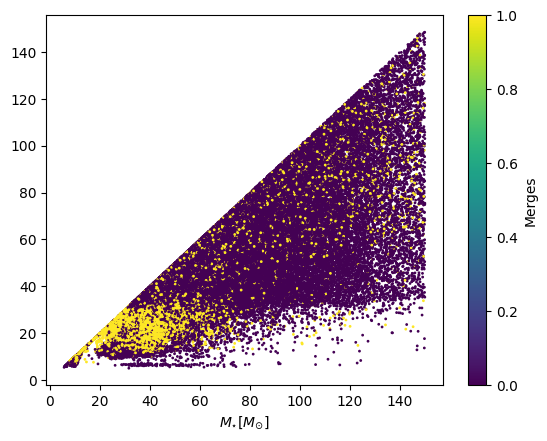

In [4]:
plt.scatter(
    double_compact_objects["Mass@ZAMS(1)"],
    double_compact_objects["Mass@ZAMS(2)"],
    s=1,
    c=double_compact_objects["Merges_Hubble_Time"],
)
cbar = plt.colorbar()
plt.xlabel("$M_{\\star} [M_{\\odot}]$")
plt.xlabel("$M_{\\star} [M_{\\odot}]$")
cbar.set_label("Merges")
plt.show()
plt.close()

Our target is when simply the `Merges_Hubble_Time` field.
We convert to an `int` because in the data, this is stored as an unsigned integer which can cause issues.

In [5]:
merges = double_compact_objects.pop("Merges_Hubble_Time").astype(int)

## Train/run our classifier

For a simple example, we use logistic regression as implemented in `scikit-learn`.
This does a terrible job, hopefully you can do better!

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [7]:
scaler = StandardScaler().fit(double_compact_objects)
scaled = scaler.transform(double_compact_objects)

In [8]:
reg = LogisticRegression().fit(scaled, merges * 2 - 1)
reg.score(scaled, merges * 2 - 1)

0.8351409707574604

Plot a confusion matrix for the classifier.

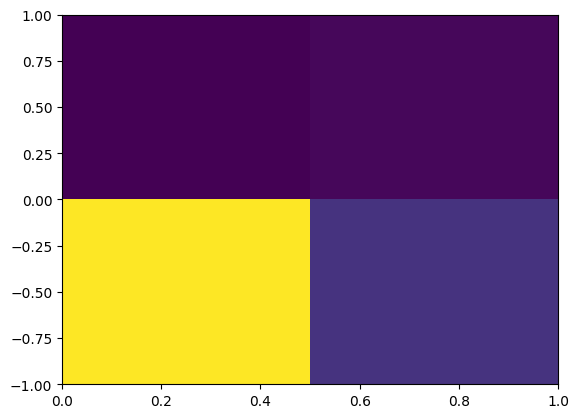

In [9]:
plt.hist2d(merges, reg.predict(scaled), bins=2)
plt.show()
plt.close()

## Extensions

To follow...